In [47]:
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsRegressor

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier 

from sklearn.svm import LinearSVC

from sklearn.svm import SVC

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern



In [3]:
df = pd.read_csv('../Data/all_merged.csv')

In [4]:
df.drop(df.columns[0], axis=1, inplace=True)

In [5]:
df = df[['cluster_nb', 'year', 'Longitude', 'Latitude', 'wealth_index']]

In [6]:
df

,cluster_nb,year,Longitude,Latitude,wealth_index
0,1997_1,1997.0,47.513320,-18.920098,0.495433
1,1997_10,1997.0,47.518390,-18.936363,0.401636
2,1997_100,1997.0,46.969551,-21.997548,-0.761039
3,1997_101,1997.0,47.118821,-21.984145,-0.658682
4,1997_102,1997.0,47.728067,-20.660401,-1.082977
...,...,...,...,...,...
2526,2018_95,2018.0,47.372711,-19.959590,-0.825694
2527,2018_96,2018.0,47.105045,-20.098791,-0.645758
2528,2018_97,2018.0,46.915565,-18.950466,2.924860
2529,2018_98,2018.0,47.181650,-19.002999,1.850475


In [7]:
wealth = df['wealth_index']

In [8]:
mean = wealth.mean()
sd = wealth.std()
q25 = wealth.quantile(q=0.25)
q75 = wealth.quantile(q=0.75)
print("mean =  %f, sd = %f, q25 =  %f, q75 =  %f" % (mean,sd,q25,q75))

mean =  0.021197, sd = 1.429725, q25 =  -1.032366, q75 =  0.778760


<AxesSubplot:xlabel='wealth_index', ylabel='Density'>

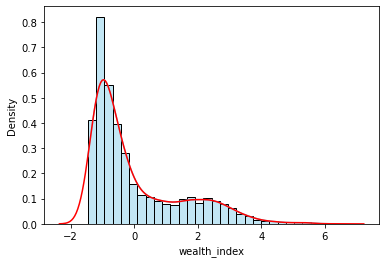

In [9]:
sns.histplot(data=wealth, stat='density', kde=True, color="skyblue")
sns.kdeplot(wealth, color='red')

Creating poverty tresholds using quantiles

In [10]:
level = []
n=df.shape[0]

for i in range(n):
    if wealth[i]<wealth.quantile(q=0.25):
        level.append(str(0))
    elif wealth.quantile(q=0.25) <= wealth[i] < wealth.mean():
        level.append(str(1))
    elif wealth.mean() <= wealth[i] < wealth.quantile(q=0.75):
        level.append(str(2))
    else:
        level.append(str(3))


In [11]:
df['level'] = level

In [12]:
df

,cluster_nb,year,Longitude,Latitude,wealth_index,level
0,1997_1,1997.0,47.513320,-18.920098,0.495433,2
1,1997_10,1997.0,47.518390,-18.936363,0.401636,2
2,1997_100,1997.0,46.969551,-21.997548,-0.761039,1
3,1997_101,1997.0,47.118821,-21.984145,-0.658682,1
4,1997_102,1997.0,47.728067,-20.660401,-1.082977,0
...,...,...,...,...,...,...
2526,2018_95,2018.0,47.372711,-19.959590,-0.825694,1
2527,2018_96,2018.0,47.105045,-20.098791,-0.645758,1
2528,2018_97,2018.0,46.915565,-18.950466,2.924860,3
2529,2018_98,2018.0,47.181650,-19.002999,1.850475,3


In [13]:
df_classification = df.drop(columns= ['cluster_nb', 'year', 'wealth_index'])

In [42]:
X = df_classification[['Longitude', 'Latitude']]
Y = df_classification['level']
Y_regression = df['wealth_index']

In [43]:
Y_regression

0       0.495433
1       0.401636
2      -0.761039
3      -0.658682
4      -1.082977
          ...   
2526   -0.825694
2527   -0.645758
2528    2.924860
2529    1.850475
2530    1.852230
Name: wealth_index, Length: 2531, dtype: float64

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=int(0.2*df.shape[0]),random_state=11)
print("Training Set Length: ", X_train.shape[0])
print("Testing Set Length: ", X_test.shape[0])

Training Set Length:  2025
Testing Set Length:  506


In [44]:
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X,Y_regression,test_size=int(0.2*df.shape[0]),random_state=11)
print("Training Set Length: ", X_train_reg.shape[0])
print("Testing Set Length: ", X_test_reg.shape[0])

Training Set Length:  2025
Testing Set Length:  506


In [46]:
# Hyper-parameters Tuning

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

knn = KNeighborsRegressor()
clf = GridSearchCV(knn, hyperparameters, cv=10)

best_model = clf.fit(X_train_reg,Y_train_reg)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

# Testing and evaluating performance

predictions_reg = best_model.predict(X_test_reg)
r2 = r2_score(Y_test_reg, predictions_reg)
print('r2 :', r2)

Best leaf_size: 4
Best p: 1
Best n_neighbors: 3
r2 : 0.6338580155817726


**Classification Methods**

In [17]:
def classification_metric(y_true, y_pred):
    table = pd.crosstab(y_true, y_pred, dropna = False)
    print(table)
    print(classification_report(y_true, y_pred))

**kNN**

In [50]:
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, Y_train)

y_pred = classifier.predict(X_test)
classification_metric(Y_test, y_pred)


col_0   0    1  2    3
level                 
0      55   54  0    2
1      49  146  8   14
2       6   24  5   15
3       2   19  3  104
              precision    recall  f1-score   support

           0       0.49      0.50      0.49       111
           1       0.60      0.67      0.63       217
           2       0.31      0.10      0.15        50
           3       0.77      0.81      0.79       128

    accuracy                           0.61       506
   macro avg       0.54      0.52      0.52       506
weighted avg       0.59      0.61      0.60       506



**Decision Tree**

In [18]:
# Optimisation of shaft depth
param_grid = [{"max_depth": range(2,10), "min_samples_split" : range(2,10), "min_samples_leaf": range(1,5) }]
tree = GridSearchCV(DecisionTreeClassifier(max_features = None , min_impurity_decrease = 1e-3, random_state = 42), scoring = "accuracy", param_grid = param_grid, cv=10, n_jobs=-1, refit = True)
treeOpt = tree.fit(X_train, Y_train)

# Optimal parameter
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (treeOpt.best_score_, treeOpt.best_params_))

Best Mean cross-validated accuracy = 0.593101, Best parameter = {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 7}


In [19]:
#Prediction on the test sample

y_hat = treeOpt.predict(X_test)
classification_metric(Y_test, y_hat)


col_0   0    1  2   3
level                
0      63   45  0   3
1      45  164  0   8
2       7   34  1   8
3       5   33  1  89
              precision    recall  f1-score   support

           0       0.53      0.57      0.55       111
           1       0.59      0.76      0.67       217
           2       0.50      0.02      0.04        50
           3       0.82      0.70      0.75       128

    accuracy                           0.63       506
   macro avg       0.61      0.51      0.50       506
weighted avg       0.63      0.63      0.60       506



In [20]:
DecisionTreeClassifier

sklearn.tree._classes.DecisionTreeClassifier

La table de contigence montre que les classes aux extrémités(0 et 3) sont généralement bien prédit 50% du temps, mais les classes 1 et 2 sont plus ambigües

**Random Forest**

In [21]:
# Parameters definition
forest = RandomForestClassifier(n_estimators = 500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, max_leaf_nodes=None, 
                                 bootstrap=True, oob_score=True)

# Training
rfFit = forest.fit(X_train,Y_train)

# Out-of-bag error on the train sample
print(1 - rfFit.oob_score_)
# Out-of-bag error on the test sample
print(1 - rfFit.score(X_test,Y_test))

0.3782716049382716
0.3754940711462451


In [22]:
param = [{"n_estimators" : range(200, 500, 100) , "max_depth" : range(10, 20, 2) }]

rf = GridSearchCV(RandomForestClassifier(random_state=42, criterion="entropy"), param, cv = 5, n_jobs=-1)

rfOpt = rf.fit(X_train, Y_train)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (rfOpt.best_score_, rfOpt.best_params_))

KeyboardInterrupt: 

In [ ]:
# Estimation of the prediction error on the test sample
rfOpt.score(X_test, Y_test)

0.6403162055335968

In [ ]:
# Prediction of the test sample
y_hat = rfOpt.predict(X_test)
classification_metric(Y_test, y_hat)

col_0   0    1  2   3
level                
0      49   60  0   2
1      30  176  1  10
2       3   33  1  13
3       2   27  1  98
              precision    recall  f1-score   support

           0       0.58      0.44      0.50       111
           1       0.59      0.81      0.69       217
           2       0.33      0.02      0.04        50
           3       0.80      0.77      0.78       128

    accuracy                           0.64       506
   macro avg       0.58      0.51      0.50       506
weighted avg       0.62      0.64      0.61       506



**Linear SVM**

In [ ]:
param=[{"C": np.linspace(0.01, 0.1, 10), "max_iter": range(8000, 11000, 1000) }]

svm= GridSearchCV(LinearSVC(), param, cv=10, n_jobs = -1, scoring = "accuracy")
svmLinOpt=svm.fit(X_train, Y_train)

print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmLinOpt.best_score_,svmLinOpt.best_params_))

Best Mean cross-validated accuracy = 0.440479, Best parameter = {'C': 0.07, 'max_iter': 8000}


In [ ]:
# Prediction of the test sample
y_hat = svmLinOpt.predict(X_test)
classification_metric(Y_test, y_hat)

col_0   0    1  3
level            
0      35   76  0
1      30  185  2
2       6   44  0
3       7  121  0
              precision    recall  f1-score   support

           0       0.45      0.32      0.37       111
           1       0.43      0.85      0.58       217
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00       128

    accuracy                           0.43       506
   macro avg       0.22      0.29      0.24       506
weighted avg       0.28      0.43      0.33       506



c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Prévisible : la pauvreté n'a aucune raison d'être linéaire selon les coordonées GPS

**SVM with polynomial kernel(degree 3)**

In [38]:
param = [{"coef0": np.linspace(0, 3, 5) }]
svm = GridSearchCV(SVC(kernel="poly"),param,cv=10,n_jobs=-1, scoring = "accuracy")
svmPolyOpt=svm.fit(X_train, Y_train)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmPolyOpt.best_score_, svmPolyOpt.best_params_))

Best Mean cross-validated accuracy = 0.418761, Best parameter = {'coef0': 1.5}


In [39]:
# Prediction of the test sample
y_hat = svmPolyOpt.predict(X_test)
classification_metric(Y_test, y_hat)

col_0    1  3
level        
0      111  0
1      215  2
2       50  0
3      128  0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.43      0.99      0.60       217
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00       128

    accuracy                           0.42       506
   macro avg       0.11      0.25      0.15       506
weighted avg       0.18      0.42      0.26       506



c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SVM with radial kernel**

In [35]:
param=[{"C" : np.linspace(1,10,10),"gamma":np.linspace(0.001, 0.1, 10)}]

svm= GridSearchCV(SVC(kernel="rbf"), param, cv=10, n_jobs=-1,scoring = "accuracy")
svmRadOpt=svm.fit(X_train, Y_train)

print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmRadOpt.best_score_,svmRadOpt.best_params_))

Best Mean cross-validated accuracy = 0.526401, Best parameter = {'C': 4.0, 'gamma': 0.08900000000000001}


In [36]:
# Prediction of the test sample
y_hat = svmRadOpt.predict(X_test)
classification_metric(Y_test, y_hat)

col_0   0    1   3
level             
0      49   54   8
1      38  135  44
2       8   30  12
3       6   37  85
              precision    recall  f1-score   support

           0       0.49      0.44      0.46       111
           1       0.53      0.62      0.57       217
           2       0.00      0.00      0.00        50
           3       0.57      0.66      0.61       128

    accuracy                           0.53       506
   macro avg       0.40      0.43      0.41       506
weighted avg       0.48      0.53      0.50       506



c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SVM with sigmoid kernel**

In [37]:
param=[{"C":np.linspace(1,10,10),"gamma":np.linspace(0.001, 0.1, 10)}]
#param=[{"coef0":np.array(range(1,11))/10}]
svm= GridSearchCV(SVC(kernel="sigmoid", coef0=0),param,cv=10,n_jobs=-1,scoring = "accuracy")
svmSigOpt=svm.fit(X_train, Y_train)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmSigOpt.best_score_,svmSigOpt.best_params_))

Best Mean cross-validated accuracy = 0.419246, Best parameter = {'C': 10.0, 'gamma': 0.001}


In [27]:
# Prediction of the test sample
y_hat = svmRadOpt.predict(X_test)
classification_metric(Y_test, y_hat)

col_0   0    1   3
level             
0      50   53   8
1      41  135  41
2       8   29  13
3       6   42  80
              precision    recall  f1-score   support

           0       0.48      0.45      0.46       111
           1       0.52      0.62      0.57       217
           2       0.00      0.00      0.00        50
           3       0.56      0.62      0.59       128

    accuracy                           0.52       506
   macro avg       0.39      0.42      0.41       506
weighted avg       0.47      0.52      0.49       506



c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ikhla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Gaussian Process**

In [ ]:
GPC = GaussianProcessClassifier(kernel = 0.5*RBF(3.0), random_state = 42, multi_class = "one_vs_rest")
GPC.fit(X_train, Y_train)
print(GPC.score(X_train, Y_train))
print(GPC.score(X_test, Y_test))

In [ ]:
GPC = GaussianProcessClassifier(kernel = Matern(3.0, nu = 1.5), random_state = 42, multi_class = "one_vs_rest")
GPC.fit(X_train, Y_train)
print(GPC.score(X_train, Y_train))
print(GPC.score(X_test, Y_test))